## 1: ライブラリのインポート!

In [1]:
import sqlite3
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit, train_test_split
# from sklearn.linear_model import LogisticRegression # 不要になるためコメントアウト
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, brier_score_loss, classification_report
import numpy as np
from typing import Optional
import os
from tqdm.notebook import tqdm

# --- Keras/TensorFlow のインポート ---
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# 出力幅を広げる設定
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

## 2: データ読み込み・前処理関数の定義 (load_and_process_pbp)

In [2]:
def load_and_process_pbp(db_path: str, limit_rows: Optional[int] = None) -> Optional[pd.DataFrame]:
    """
    SQLiteデータベースからプレイバイプレイデータを読み込み、データ型を処理し、
    ホームチームの勝敗情報を計算して元のデータに結合します。
    (チャンク読み込みとプログレスバー表示に対応)
    """
    print(f"--- Starting data loading and processing ---")
    print(f"Database path: {db_path}")
    if limit_rows:
        print(f"Row limit: {limit_rows}")
    else:
        print("Row limit: None (loading all rows)")

    try:
        # 1. SQLiteデータベースへの接続
        print("Connecting to database...")
        conn = sqlite3.connect(db_path)
        print("Database connection successful.")

        # --- プログレスバー用に全体の行数を先に取得 ---
        total_rows_to_load = limit_rows
        if total_rows_to_load is None:
            print("Determining total row count for progress bar...")
            # limitがない場合はテーブルの全行数を取得
            count_query = "SELECT COUNT(*) FROM play_by_play;"
            total_rows_to_load = pd.read_sql_query(count_query, conn).iloc[0, 0]
            print(f"Total rows in table: {total_rows_to_load}")

        # 2. SQLクエリの構築
        query = """
        SELECT
            game_id, eventnum, eventmsgtype, eventmsgactiontype, 
            period, pctimestring,
            homedescription, neutraldescription, visitordescription,
            score, scoremargin
        FROM
            play_by_play
        """
        if limit_rows:
            query += f" LIMIT {limit_rows};"
        else:
            query += ";"

        # --- チャンクでデータを読み込み、プログレスバーを表示 ---
        chunk_size = 100000  # 一度に読み込む行数（この値はPCのメモリに応じて調整可能）
        print(f"Loading data in chunks of {chunk_size} rows...")
        
        # chunksizeを指定すると、DataFrameのイテレータ（分割されたデータ）が返る
        iterator = pd.read_sql_query(query, conn, chunksize=chunk_size)
        
        # tqdmでプログレスバーを設定（total=チャンクの総数）
        num_chunks = (total_rows_to_load + chunk_size - 1) // chunk_size
        
        list_of_dfs = []
        # イテレータをtqdmでラップすると、ループの進捗が表示される
        for chunk_df in tqdm(iterator, total=num_chunks, desc="Loading data"):
            list_of_dfs.append(chunk_df)
        
        # 読み込んだ全てのチャンクを一つのDataFrameに結合
        print("\nConcatenating all loaded chunks...")
        df = pd.concat(list_of_dfs, ignore_index=True)
        print(f"Successfully loaded {len(df)} rows into DataFrame.")

        # 4. データベース接続を閉じる
        conn.close()
        print("Database connection closed.")

        # 5. データ型の確認と変換（ここから先の処理は元のコードと同じ）
        print("Processing data types...")
        df['game_id'] = df['game_id'].astype(str)
        df['pctimestring'] = df['pctimestring'].astype(str)
        df['score'] = df['score'].astype(str)
        df['scoremargin'] = df['scoremargin'].astype(str)
        df['eventnum'] = pd.to_numeric(df['eventnum'], errors='coerce')
        df['eventmsgtype'] = pd.to_numeric(df['eventmsgtype'], errors='coerce')
        df['eventmsgactiontype'] = pd.to_numeric(df['eventmsgactiontype'], errors='coerce') 
        df['period'] = pd.to_numeric(df['period'], errors='coerce')
        desc_cols = ['homedescription', 'neutraldescription', 'visitordescription']
        for col in desc_cols:
            df[col] = df[col].fillna('')
        print("Data type processing complete.")

        # --- 最終スコアの取得と勝敗判定 ---
        print("\nAttempting to determine game outcomes...")
        game_outcomes = pd.Series(dtype=int)

        end_game_events = df[(df['eventmsgtype'] == 13) & (df['score'].str.contains(' - ', na=False))].copy()

        if not end_game_events.empty:
            end_game_events = end_game_events.dropna(subset=['period'])
            if not end_game_events.empty:
                end_game_events['period'] = end_game_events['period'].astype(int)
                final_events = end_game_events.sort_values('period').groupby('game_id').last()

                if 'score' in final_events.columns:
                    scores_split = final_events['score'].str.split(' - ', expand=True)
                    scores_split.columns = ['home_score', 'visitor_score']
                    scores_split['home_score'] = pd.to_numeric(scores_split['home_score'], errors='coerce')
                    scores_split['visitor_score'] = pd.to_numeric(scores_split['visitor_score'], errors='coerce')
                    scores_split = scores_split.dropna(subset=['home_score', 'visitor_score'])

                    if not scores_split.empty:
                        scores_split['home_win'] = (scores_split['home_score'] > scores_split['visitor_score']).astype(int)
                        game_outcomes = scores_split['home_win']
                        print(f"Determined outcomes for {len(game_outcomes)} games.")
                        if limit_rows:
                            print("[Warning] Game outcomes may be incomplete due to the row limit.")

        print("Merging game outcomes back to the main DataFrame...")
        if not game_outcomes.empty:
             df_with_outcome = df.merge(game_outcomes.rename('home_win'), on='game_id', how='left')
        else:
             print("No game outcomes determined, adding 'home_win' column with NaN.")
             df['home_win'] = pd.NA
             df_with_outcome = df

        print("--- Data loading and processing finished ---")
        return df_with_outcome

    except sqlite3.Error as e:
        print(f"\n--- Database Error ---")
        print(f"An error occurred while interacting with the database: {e}")
        return None
    except FileNotFoundError:
        print(f"\n--- File Not Found Error ---")
        print(f"Error: The database file was not found at the specified path: {db_path}")
        return None
    except Exception as e:
        print(f"\n--- An Unexpected Error Occurred ---")
        print(f"Error details: {e}")
        return None

## 3: 特徴量エンジニアリング用関数の定義

In [3]:
def parse_time_to_seconds(time_str):
    """ 'MM:SS' 形式の文字列を秒に変換 """
    if isinstance(time_str, str) and ':' in time_str:
        try:
            minutes, seconds = map(int, time_str.split(':'))
            return minutes * 60 + seconds
        except ValueError:
            return None # パースエラー
    return None

def calculate_seconds_elapsed(row):
    """ 試合開始からの経過秒数を計算 """
    period = row['period']
    pctimestring = row['pctimestring']

    if pd.isna(period) or period < 1:
        return None

    seconds_in_period = parse_time_to_seconds(pctimestring)
    if seconds_in_period is None:
        return None

    seconds_per_period = 720 if period <= 4 else 300
    seconds_elapsed_in_current_period = seconds_per_period - seconds_in_period

    if seconds_elapsed_in_current_period < 0 or seconds_elapsed_in_current_period > seconds_per_period:
         return None

    if period <= 4:
        total_seconds_elapsed = (period - 1) * 720 + seconds_elapsed_in_current_period
    else:
        total_seconds_elapsed = 4 * 720 + (period - 5) * 300 + seconds_elapsed_in_current_period
    return total_seconds_elapsed

def process_score_margin(margin_str):
    """ scoremargin を数値に変換 ('TIE' -> 0) """
    if margin_str == 'TIE':
        return 0
    elif pd.isna(margin_str) or margin_str == '':
         return None
    else:
        try:
            return int(str(margin_str).replace('+', ''))
        except ValueError:
            return None

## 4 設定とデータ読み込みの実行

In [4]:
#研究室PC用path
#db_file = r'C:\Users\amilu\Projects\vsCodeFile\PBL\nba.sqlite'
#ノートPC用path
db_file = r'C:\Programing\PBL\nba.sqlite'

limit_rows = 45616 #9999808
#45616
# limit_rows = None # 全データの場合

df_processed = load_and_process_pbp(db_file, limit_rows=limit_rows)

# 読み込み結果の確認
if df_processed is not None:
    print("\nShape of loaded data:", df_processed.shape)
    df_processed.head() # 先頭数行を表示
else:
    print("Data loading failed.")

--- Starting data loading and processing ---
Database path: C:\Programing\PBL\nba.sqlite
Row limit: 45616
Connecting to database...
Database connection successful.
Loading data in chunks of 100000 rows...


Loading data:   0%|          | 0/1 [00:00<?, ?it/s]


Concatenating all loaded chunks...
Successfully loaded 45616 rows into DataFrame.
Database connection closed.
Processing data types...
Data type processing complete.

Attempting to determine game outcomes...
Determined outcomes for 99 games.
[Warning] Game outcomes may be incomplete due to the row limit.
Merging game outcomes back to the main DataFrame...
--- Data loading and processing finished ---

Shape of loaded data: (45616, 12)


## 5: 特徴量エンジニアリングの実行

In [5]:
if df_processed is not None:
    print("\n--- Feature Engineering ---")

    print("Calculating total seconds elapsed...")
    df_processed['seconds_elapsed'] = df_processed.apply(calculate_seconds_elapsed, axis=1)

    print("Processing score margin...")
    # Step 1: 'TIE' や数値変換可能なものを数値に変換 (NoneはNoneのまま)
    df_processed['numeric_score_margin'] = df_processed['scoremargin'].apply(process_score_margin)

    # Step 2: game_id ごとに並べ替え、欠損値 (None) を直前の有効な値で前方補完 (ffill)
    print("Forward filling missing 'numeric_score_margin' within each game...")
    # game_id と eventnum でソートすることが重要
    df_processed = df_processed.sort_values(by=['game_id', 'eventnum'])
    df_processed['numeric_score_margin'] = df_processed.groupby('game_id')['numeric_score_margin'].ffill()

    # ffill 後も NaN が残る場合がある（ゲームの最初の数プレイなど、前に有効な値がない場合）
    # これらは後続の dropna で処理されるか、別途 0 などで埋める判断も可能
    # print("NaN count in numeric_score_margin after ffill:", df_processed['numeric_score_margin'].isnull().sum())
    # 2.3 Generate Composite Event ID
    print("Generating composite event ID...")
    # eventmsgtype と eventmsgactiontype が数値であることを確認 (NaNの場合は計算結果もNaNになる)
    # 複合IDの計算前に、これらのカラムの欠損値処理が必要か検討
    # 例: df_processed['eventmsgtype'].fillna(0, inplace=True) # 欠損を0で埋める場合
    #     df_processed['eventmsgactiontype'].fillna(0, inplace=True)
    
    # もし欠損値のまま計算すると、結果がNaNになるため、後続のdropnaで除外されるか、
    # またはfillna(例えば -1 や特定の予約ID) で埋める
    df_processed['composite_event_id'] = (df_processed['eventmsgtype'] * 1000 + df_processed['eventmsgactiontype'])
    # 欠損値から生じたNaNを、例えば不明なID (-1など) で埋める場合
    # df_processed['composite_event_id'] = df_processed['composite_event_id'].fillna(-1).astype(int)
    print("Composite event ID generation complete.")


    # 結果の確認
    print("\nPreview of processed time, score margin, and composite event ID features:")
    print(df_processed[['game_id', 'eventnum', 'eventmsgtype', 'eventmsgactiontype', 'composite_event_id', 'seconds_elapsed', 'numeric_score_margin']].head(15))


--- Feature Engineering ---
Calculating total seconds elapsed...
Processing score margin...
Forward filling missing 'numeric_score_margin' within each game...
Generating composite event ID...
Composite event ID generation complete.

Preview of processed time, score margin, and composite event ID features:
         game_id  eventnum  eventmsgtype  eventmsgactiontype  composite_event_id  seconds_elapsed  numeric_score_margin
2225  0029600001         1            12                   0               12000                0                   NaN
2226  0029600001         2            10                   0               10000                0                   NaN
2227  0029600001         4             1                   5                1005               21                  -2.0
2228  0029600001         5             6                   2                6002               21                  -2.0
2229  0029600001         6             3                  10                3010            

## 6: モデル用データ準備 (フィルタリング)

In [6]:
if df_processed is not None:
    print("\n--- Data Preparation for Modeling ---")
    print("Filtering data for modeling...")
    initial_rows = len(df_processed)
    
    # 欠損値の確認 (フィルタリング前)
    # print("NaN counts before filtering:")
    # print(df_processed[['home_win', 'seconds_elapsed', 'numeric_score_margin', 'period']].isnull().sum())

    model_df = df_processed.dropna(subset=['home_win', 'seconds_elapsed', 'numeric_score_margin', 'period', 'composite_event_id'])
    model_df = model_df[model_df['period'] > 0]
    model_df = model_df[model_df['eventmsgtype'] != 12] # "Start Period" イベントを除外

    filtered_rows = len(model_df)
    print(f"Rows before filtering: {initial_rows}")
    print(f"Rows after filtering invalid/unnecessary entries: {filtered_rows}")
    
    if filtered_rows > 0:
        model_df.head()
    else:
        print("No data left after filtering.")



--- Data Preparation for Modeling ---
Filtering data for modeling...
Rows before filtering: 45616
Rows after filtering invalid/unnecessary entries: 44791


## 7: 特徴量とターゲットの選択、訓練/テスト分割,LSTM準備

In [18]:
# --- One-Hotエンコーディングの適用とLSTM用のデータ準備 (多対多モデル用) ---

if 'model_df' in locals() and not model_df.empty:
    print("\n--- Applying One-Hot Encoding for 'composite_event_id' ---")
    
    # SettingWithCopyWarning を回避するために .copy() を使用
    model_df_with_ohe = model_df.copy()
    
    # One-Hotエンコーディングを適用
    model_df_with_ohe = pd.get_dummies(model_df_with_ohe, columns=['composite_event_id'], prefix='event')
    
    # --- 多対多LSTM用のデータ形式に変換 ---
    print("\n--- Preparing data for Many-to-Many LSTM ---")
    
    # 特徴量を定義: 基本特徴量 + One-Hotエンコードされた全イベント列
    base_features = ['numeric_score_margin', 'seconds_elapsed']
    one_hot_features = [col for col in model_df_with_ohe.columns if col.startswith('event_')]
    features = base_features + one_hot_features
    target = 'home_win'
    
    print(f"Total number of features after One-Hot Encoding: {len(features)}")
    
    # データをゲームごとにグループ化
    grouped = model_df_with_ohe.groupby('game_id')
    
    # ゲームごとの特徴量シーケンスと、対応するターゲットのシーケンスを作成
    X_sequences = [group[features].values for name, group in grouped]
    y_sequences = [group[target].values for name, group in grouped]
    
    # パディング処理：シーケンスの長さを揃える
    max_len = max(len(seq) for seq in X_sequences)
    X_padded = pad_sequences(X_sequences, maxlen=max_len, padding='pre', dtype='float32')
    y_padded = pad_sequences(y_sequences, maxlen=max_len, padding='pre', dtype='float32')
    
    # LSTMの出力形式に合わせるため、yの次元を (サンプル数, タイムステップ数, 1) に変更
    y_padded_lstm = np.expand_dims(y_padded, -1)
    
    # --- データの分割 (ゲーム単位) ---
    game_indices = np.arange(len(X_padded))
    y_for_stratify = np.array([seq[-1] for seq in y_sequences])
    train_indices, test_indices = train_test_split(game_indices, test_size=0.2, random_state=42, stratify=y_for_stratify)
    
    X_train_lstm, X_test_lstm = X_padded[train_indices], X_padded[test_indices]
    y_train_lstm, y_test_lstm = y_padded_lstm[train_indices], y_padded_lstm[test_indices]

    # --- スケーリング ---
    scaler = StandardScaler()
    n_samples_train, n_timesteps_train, n_features_train = X_train_lstm.shape
    X_train_2d = X_train_lstm.reshape(-1, n_features_train)
    scaler.fit(X_train_2d)
    
    X_train_scaled_2d = scaler.transform(X_train_2d)
    X_train_scaled_lstm = X_train_scaled_2d.reshape(n_samples_train, n_timesteps_train, n_features_train)

    n_samples_test, n_timesteps_test, n_features_test = X_test_lstm.shape
    X_test_2d = X_test_lstm.reshape(-1, n_features_test)
    X_test_scaled_2d = scaler.transform(X_test_2d)
    X_test_scaled_lstm = X_test_scaled_2d.reshape(n_samples_test, n_timesteps_test, n_features_test)

    print(f"Padded sequence length (max_len): {max_len}")
    print(f"X_train shape for LSTM: {X_train_scaled_lstm.shape}")
    print(f"y_train shape for LSTM: {y_train_lstm.shape}")

else:
    print("Skipping data preparation as model_df is not available.")


--- Applying One-Hot Encoding for 'composite_event_id' ---

--- Preparing data for Many-to-Many LSTM ---
Total number of features after One-Hot Encoding: 80
Padded sequence length (max_len): 528
X_train shape for LSTM: (79, 528, 80)
y_train shape for LSTM: (79, 528, 1)


##  10: モデルの定義とコンパイル

In [19]:
if 'X_train_scaled_lstm' in locals():
    print("\n--- Defining and Compiling Many-to-Many LSTM Model ---")
    
    model = Sequential([
        # return_sequences=True に変更して、各タイムステップの出力を次に渡す
        LSTM(32, input_shape=(X_train_scaled_lstm.shape[1], X_train_scaled_lstm.shape[2]), return_sequences=True),
        Dropout(0.3),
        # TimeDistributedを使って、各タイムステップの出力にDenseレイヤーを適用
        TimeDistributed(Dense(16, activation='relu')),
        Dropout(0.3),
        TimeDistributed(Dense(1, activation='sigmoid'))
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()
else:
    print("Skipping model definition as LSTM training data is not available.")


--- Defining and Compiling Many-to-Many LSTM Model ---


c:\Users\amilu\anaconda3\envs\pbl\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 528, 32)        │        14,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 528, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 528, 16)        │           528 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 528, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 528, 1)         │            17 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,009 (58.63 KB)

 Trainable params: 15,009 (58.63 KB)

 Non-trainable params: 0 (0.00 B)

## 11: モデルの訓練

In [20]:
if 'model' in locals():
    print("\n--- Training LSTM Model ---")
    
    # 過学習を防ぐためのEarlyStopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    history = model.fit(X_train_scaled_lstm, y_train_lstm,
                        epochs=50,
                        batch_size=16,
                        validation_split=0.2, # 訓練データの一部を検証用に使う
                        callbacks=[early_stopping])
    
    print("Model training complete.")
else:
    print("Skipping model training as the model is not defined.")


--- Training LSTM Model ---
Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 80s 6s/step - accuracy: 0.5684 - loss: 0.6731 - val_accuracy: 0.6502 - val_loss: 0.6292
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 400ms/step - accuracy: 0.6102 - loss: 0.6410 - val_accuracy: 0.6701 - val_loss: 0.6100
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 458ms/step - accuracy: 0.6384 - loss: 0.6193 - val_accuracy: 0.6821 - val_loss: 0.5961
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 373ms/step - accuracy: 0.6487 - loss: 0.6094 - val_accuracy: 0.6902 - val_loss: 0.5869
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step - accuracy: 0.6998 - loss: 0.5789 - val_accuracy: 0.6953 - val_loss: 0.5782
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step - accuracy: 0.6749 - loss: 0.5878 - val_accuracy: 0.6928 - val_loss: 0.5706
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step - accuracy: 0.6994 - loss: 0.5657 - val_accuracy: 0.6986 - val_loss: 0.5617
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 393ms/step - accuracy: 0.6980 - loss: 0.5703 - val_a

## 12:予測と評価

In [21]:
if 'model' in locals() and 'X_test_scaled_lstm' in locals():
    print("\n--- Prediction and Evaluation with Many-to-Many LSTM ---")
    
    # 予測（各ゲームの各プレイの勝利確率）
    y_pred_proba_3d = model.predict(X_test_scaled_lstm)
    
    # --- 評価のためにパディング部分を除外 ---
    # 元のテストシーケンスの長さを取得
    test_game_ids = [name for i, (name, group) in enumerate(grouped) if i in test_indices]
    original_lengths = [len(group) for name, group in grouped if name in test_game_ids]
    
    # パディングを除いた予測値と真の値を平坦化
    y_pred_flat = []
    y_true_flat = []
    for i, length in enumerate(original_lengths):
        # 予測結果からパディング部分を除外
        valid_preds = y_pred_proba_3d[i, -length:, 0]
        y_pred_flat.extend(valid_preds)
        
        # 正解データからパディング部分を除外
        valid_true = y_test_lstm[i, -length:, 0]
        y_true_flat.extend(valid_true)

    y_pred_class_flat = (np.array(y_pred_flat) > 0.5).astype(int)

    # モデル評価 (プレイ単位)
    accuracy = accuracy_score(y_true_flat, y_pred_class_flat)
    auc = roc_auc_score(y_true_flat, y_pred_flat)
    logloss = log_loss(y_true_flat, y_pred_flat)
    brier = brier_score_loss(y_true_flat, y_pred_flat)

    print(f"LSTM Model Evaluation Results (Per Play):")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  ROC AUC:  {auc:.4f}")
    print(f"  Log Loss: {logloss:.4f}")
    print(f"  Brier Score: {brier:.4f}")

    # --- 予測結果を元のテストデータに戻す ---
    model_df_test = model_df_encoded[model_df_encoded['game_id'].isin(test_game_ids)].copy()
    model_df_test['win_probability_pred'] = y_pred_flat

    print("\nFirst 15 rows of test data with time-varying win probability:")
    display_cols = ['game_id', 'eventnum', 'period', 'pctimestring', 'numeric_score_margin', 'home_win', 'win_probability_pred']
    print(model_df_test[display_cols].head(15))
else:
    print("Skipping prediction as model or test data is not available.")


--- Prediction and Evaluation with Many-to-Many LSTM ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
LSTM Model Evaluation Results (Per Play):
  Accuracy: 0.6348
  ROC AUC:  0.7088
  Log Loss: 0.6135
  Brier Score: 0.2166

First 15 rows of test data with time-varying win probability:
        game_id  eventnum  period pctimestring  numeric_score_margin  home_win  win_probability_pred
909  0029600002         7       1        11:36                   1.0         1              0.473525
910  0029600002         8       1        11:36                   2.0         1              0.474836
911  0029600002        10       1        11:00                   2.0         1              0.460481
912  0029600002        11       1        10:54                   2.0         1              0.529390
913  0029600002        12       1        10:53                   0.0         1              0.461812
914  0029600002        13       1        10:48                   0.0         1              0.502613
915  0029600002

## csv出力

In [ ]:
# 最終的なテストデータフレームが存在し、空でないことを確認
if 'model_df_test' in locals() and isinstance(model_df_test, pd.DataFrame) and not model_df_test.empty:
    
    # --- ここでCSVに出力する試合数を設定 ---
    num_games_to_export = 3  # 例として3試合に設定（この数値を自由に変更してください）
    
    # テストデータに含まれるユニークなゲームIDを取得
    unique_test_games = model_df_test['game_id'].unique()
    
    if len(unique_test_games) > 0:
        # 出力するゲームIDを、設定した数だけスライスして取得
        games_to_export = unique_test_games[:num_games_to_export]
        
        # 選択されたゲームIDのデータのみを新しいDataFrameに抽出
        df_for_export = model_df_test[model_df_test['game_id'].isin(games_to_export)]
        
        print(f"\nExporting data for {len(games_to_export)} games (out of {len(unique_test_games)} total test games).")

        # 出力ファイル名を分かりやすく動的に設定
        output_csv_path = f'lstm_predictions_{len(games_to_export)}_games.csv'
        print(f"--- Exporting Final Test Predictions to CSVA ---")
        
        try:
            # 抽出したデータフレーム（df_for_export）をCSVファイルに保存
            df_for_export.to_csv(output_csv_path, index=False, encoding='utf-8')
            print(f"Successfully exported test predictions to: {output_csv_path}")
            
        except Exception as e:
            print(f"An error occurred while exporting to CSV: {e}")
            
    else:
        print("\nNo games found in the test set to export.")
        
else:
    print("\nSkipping CSV export because the final test DataFrame ('model_df_test') was not found or is empty.")


print("\n--- Win probability prediction notebook execution finished ---")


Exporting data for 3 games (out of 20 total test games).
--- Exporting Final Test Predictions to CSV ---
Successfully exported test predictions to: lstm_predictions_3_games.csv

--- Win probability prediction notebook execution finished ---


## モメンタムの取り出し

--- Calculating Win Probability Added (WPA) for each event ---
--- 詳細なイベントごとのWPAインパクト Top15 ---

[勝率を最も高めたイベント (ホームチーム)]
                        mean  count   event_name
composite_event_id                              
28                  0.042245      1  不明なID(4001)
39                  0.033465      1  不明なID(5010)
66                  0.029482      2  不明なID(7004)
45                  0.027128      2  不明なID(5016)
22                  0.025078      3  不明なID(3014)
55                  0.023760      2  不明なID(6010)
60                  0.022765      4  不明なID(6016)
32                  0.019721     21  不明なID(5003)
40                  0.019257     22  不明なID(5011)
61                  0.017283     12  不明なID(6017)
42                  0.016794      4  不明なID(5013)
75                  0.016611     24      ジャンプボール
10                  0.016135     10  不明なID(2002)
25                  0.013402      2  不明なID(3017)
16                  0.012634      3  不明なID(2008)

[勝率を最も下げたイベント (ホームチーム)]
                     

C:\Users\amilu\AppData\Local\Temp\ipykernel_15284\119313732.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=top_events['mean'], y=top_events['event_name'], palette='Greens_r')
C:\Users\amilu\AppData\Local\Temp\ipykernel_15284\119313732.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x=bottom_events['mean'], y=bottom_events['event_name'], palette='Reds')
C:\Users\amilu\AppData\Local\Temp\ipykernel_15284\119313732.py:72: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) Arial.
  plt.tight_layout(rect=[0, 0, 1, 0.96])
C:\Users\amilu\AppData\Local\Temp\ipykernel_15284\119313732.py:72: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEO

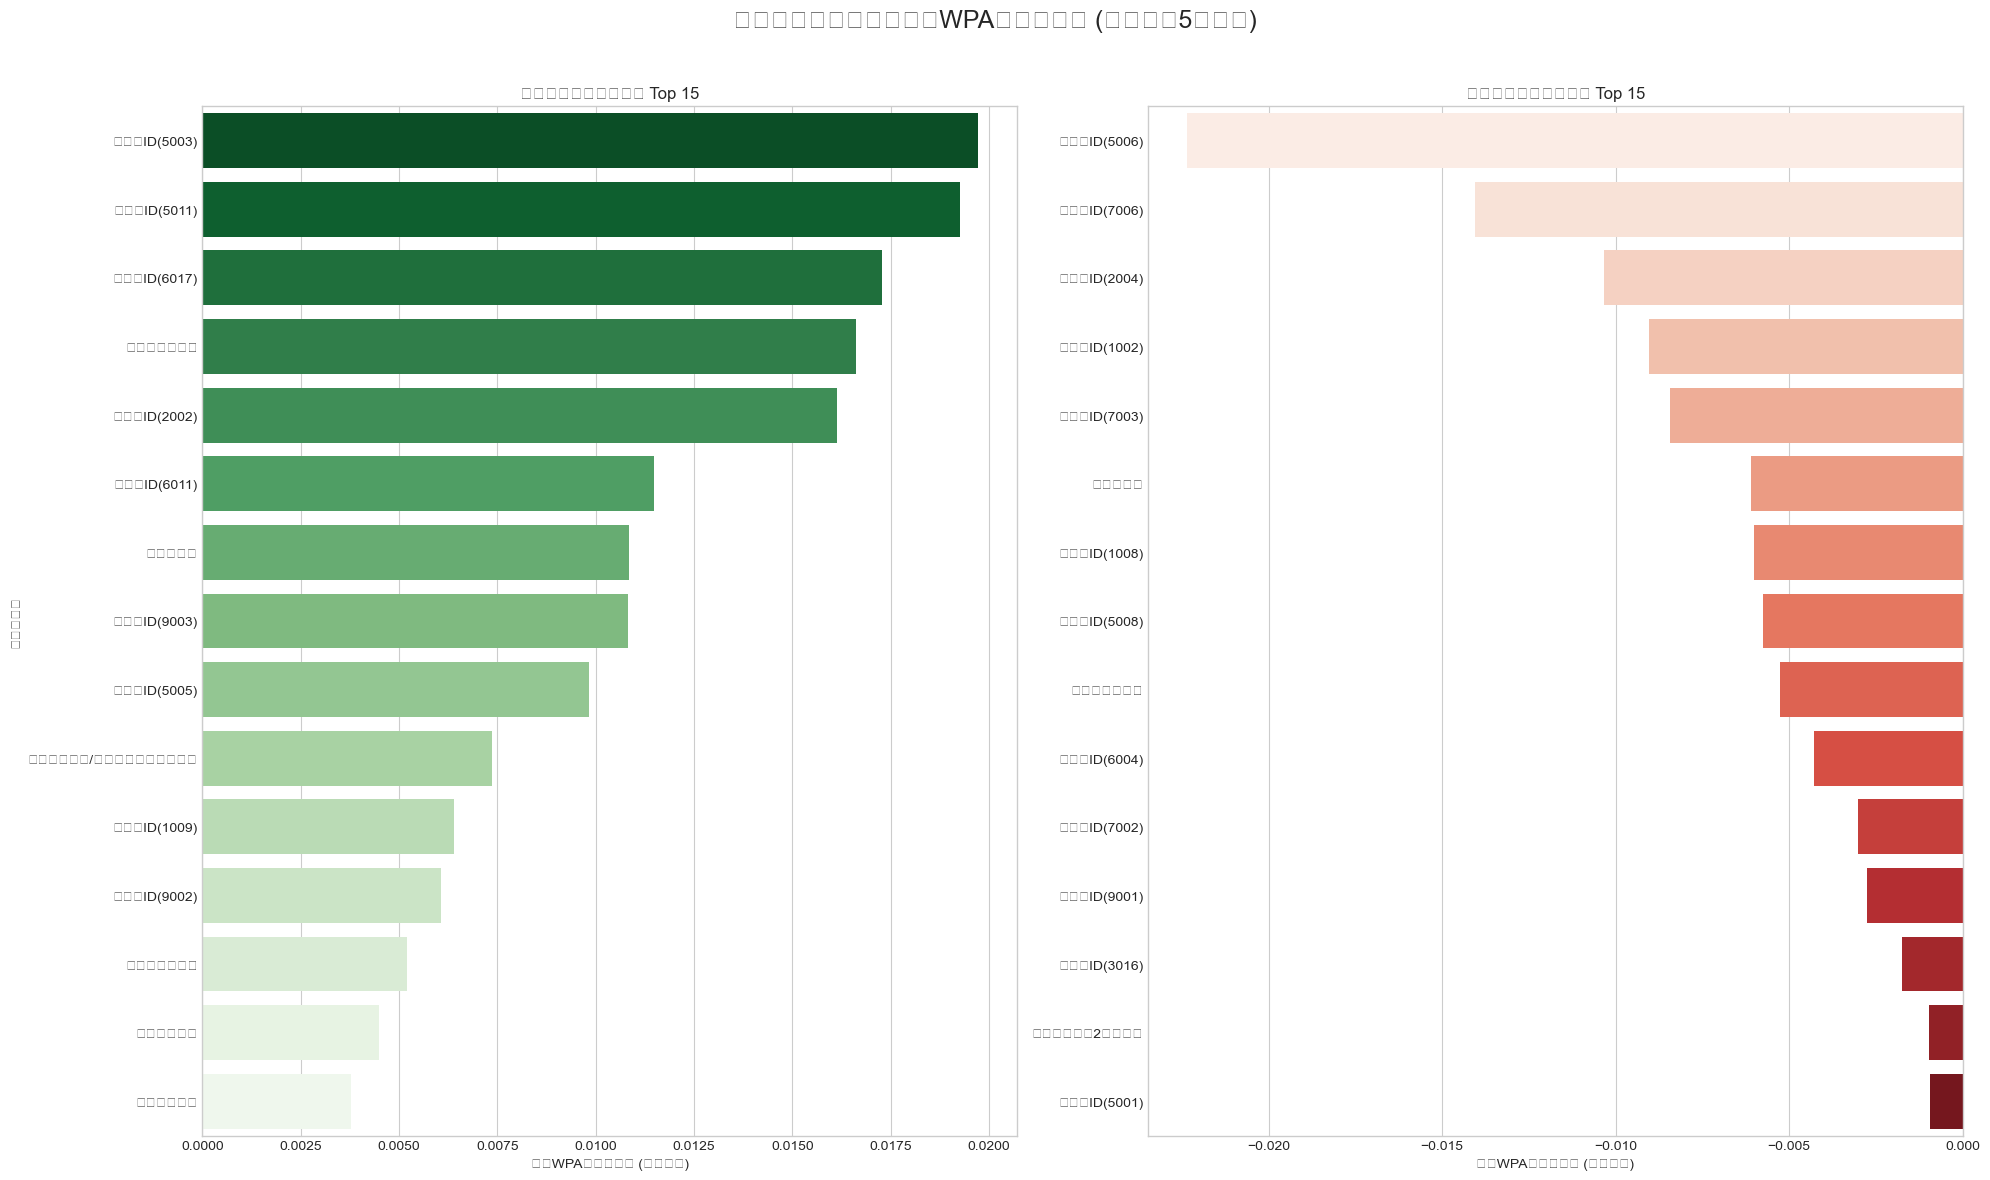

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

# 分析対象のデータフレームが存在することを確認
if 'model_df_test' in locals() and isinstance(model_df_test, pd.DataFrame) and not model_df_test.empty:
    
    print("--- Calculating Win Probability Added (WPA) for each event ---")

    # 1. 元のIDからイベント名へのマッピング辞書を定義
    event_id_to_name_map = {
        1000: 'FG成功(その他)', 2000: 'FG失敗(その他)', 3000: 'フリースロー', 4000: 'リバウンド',
        5000: 'ターンオーバー(その他)', 6000: 'ファウル(その他)', 7000: 'バイオレーション', 8000: '選手交代',
        9000: 'タイムアウト', 10000: 'ジャンプボール', 11000: '退場', 12000: 'ピリオド開始',
        13000: 'ピリオド終了', 18000: 'その他',
        1001: 'ジャンプショット成功', 1005: 'レイアップ成功', 1007: 'ダンク成功',
        1041: 'アリウープ成功', 1042: 'ドライビングレイアップ成功', 1050: 'ランニングダンク成功',
        1052: 'アリウープダンク成功', 1055: 'フックショット成功', 1066: 'ジャンプバンクショット成功',
        1108: 'カッティングダンクショット成功',
        2001: 'ジャンプショット失敗', 2005: 'レイアップ失敗', 2007: 'ダンク失敗',
        3010: 'フリースロー1本目成功', 3011: 'フリースロー2本目成功', 3012: 'フリースロー失敗',
        5002: 'ボールロスト', 5004: 'トラベリング/オフェンシブファウル', 5040: 'アウトオブバウンズ',
        6001: 'パーソナルファウル', 6002: 'シューティングファウル', 6003: 'テクニカルファウル'
    }
    
    # 2. LabelEncoder（le）を使って、エンコード後の連番(0,1,2..)からイベント名へのマッピング辞書を動的に作成
    # le.classes_ にはエンコード対象となった元のIDが連番の昇順で格納されている
    encoded_label_to_name_map = {i: event_id_to_name_map.get(original_id, f'不明なID({original_id})') for i, original_id in enumerate(le.classes_)}

    # 3. WPAインパクトを計算
    model_df_test['win_prob_before'] = model_df_test.groupby('game_id')['win_probability_pred'].shift(1)
    model_df_test['wpa_impact'] = model_df_test['win_probability_pred'] - model_df_test['win_prob_before']
    wpa_df = model_df_test.dropna(subset=['wpa_impact'])
    
    # 4. エンコード後のID ごとにWPAインパクトの平均と発生回数を計算
    # (ここの'composite_event_id'列はエンコード後の0,1,2..になっている)
    event_impact = wpa_df.groupby('composite_event_id')['wpa_impact'].agg(['mean', 'count'])
    
    # 新しく作成したマッピング辞書を使ってイベント名を追加
    event_impact['event_name'] = event_impact.index.map(encoded_label_to_name_map)
    event_impact = event_impact.sort_values(by='mean', ascending=False)
    
    print("--- 詳細なイベントごとのWPAインパクト Top15 ---")
    print("\n[勝率を最も高めたイベント (ホームチーム)]")
    print(event_impact.head(15))
    
    print("\n[勝率を最も下げたイベント (ホームチーム)]")
    print(event_impact.tail(15).sort_values(by='mean'))

    # 5. 結果の可視化（詳細イベント別）
    # 発生回数が少なすぎるイベントはノイズが大きいため、一定回数以上のイベントに絞って可視化
    event_impact_filtered = event_impact[event_impact['count'] >= 5]
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(20, 12))
    fig.suptitle('詳細イベントごとの平均WPAインパクト (発生回数5回以上)', fontsize=18)

    # 勝率を上げるイベント
    top_events = event_impact_filtered.head(15)
    sns.barplot(ax=axes[0], x=top_events['mean'], y=top_events['event_name'], palette='Greens_r')
    axes[0].set_title('勝率を上げるイベント Top 15')
    axes[0].set_xlabel('平均WPAインパクト (勝率上昇)')
    axes[0].set_ylabel('イベント名')

    # 勝率を下げるイベント
    bottom_events = event_impact_filtered.tail(15).sort_values(by='mean', ascending=True)
    sns.barplot(ax=axes[1], x=bottom_events['mean'], y=bottom_events['event_name'], palette='Reds')
    axes[1].set_title('勝率を下げるイベント Top 15')
    axes[1].set_xlabel('平均WPAインパクト (勝率下降)')
    axes[1].set_ylabel('')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

else:
    print("Cannot perform analysis because 'model_df_test' is not available.")